<a href="https://colab.research.google.com/github/Sam1rShaban1/Cross-Network-LoRaMesher/blob/main/Air_Quality_Forecast.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Importing libraries

In [9]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import os

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split # Although we'll do manual split
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import (
    Input, Conv1D, MaxPooling1D, Bidirectional, LSTM, GRU,
    Dropout, Dense, GlobalMaxPooling1D, BatchNormalization
)
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.optimizers import Adam, AdamW

print("TensorFlow Version:", tf.__version__)


TensorFlow Version: 2.18.0


Configuration & Constants

In [134]:
PM25_DATA_FILE = 'cleaned_tetovo_air_quality.csv'
WEATHER_DATA_FILE = 'tetovo_hourly_weather.csv'

# Target & Features
TARGET_COLUMN = ' pm25'
BASE_POLLUTANT_COLUMNS = [' pm10', ' o3', ' no2', ' so2', ' co']
ALL_POLLUTANT_COLUMNS = [TARGET_COLUMN] + BASE_POLLUTANT_COLUMNS

# Weather features to select after aggregation (adjust based on availability and importance)
WEATHER_FEATURES_TO_USE = [
    'temp_mean', 'temp_min', 'temp_max', 'rhum_mean', 'prcp_sum',
    'wspd_mean', 'wspd_max', 'pres_mean' # Add others like 'wdir_mean', 'snow_sum' if desired/reliable
]

# Time Series Parameters (TUNABLE)
SEQUENCE_LENGTH = 14
N_LAGS = [1, 2, 3, 7]
ROLLING_WINDOWS = [3, 7]

# Data Split Ratios
TRAIN_PCT = 0.7
VAL_PCT = 0.25

# Model Hyperparameters (TUNABLE STARTING POINTS)
CONV_FILTERS = 64
KERNEL_SIZE = 5
GRU_UNITS_1 = 256
GRU_UNITS_2 = 128
DENSE_UNITS_1 = 64
DENSE_UNITS_2 = 32
DROPOUT_RATE = 0.3
USE_BATCH_NORM = True

# Training Hyperparameters (TUNABLE STARTING POINTS)
INITIAL_LEARNING_RATE = 4e-4
EPOCHS = 150
BATCH_SIZE = 32
EARLY_STOPPING_PATIENCE = 20
LR_PATIENCE = 10
LR_FACTOR = 0.1
MIN_LR = 5e-6

Load Data

In [135]:
print(f"\n--- Loading PM2.5 Data from {PM25_DATA_FILE} ---")
if not os.path.exists(PM25_DATA_FILE):
    print(f"Error: PM2.5 Data file '{PM25_DATA_FILE}' not found.")
    exit()

df_pm25 = pd.read_csv(PM25_DATA_FILE, parse_dates=['date'], index_col='date')
print(f"Original PM2.5 data shape: {df_pm25.shape}")
df_pm25.sort_index(inplace=True)
print(f"Original PM2.5 data date range: {df_pm25.index.min()} to {df_pm25.index.max()}")


--- Loading PM2.5 Data from cleaned_tetovo_air_quality.csv ---
Original PM2.5 data shape: (3553, 6)
Original PM2.5 data date range: 2015-04-18 00:00:00 to 2025-04-13 00:00:00


Clean & Impute PM2.5 Data

In [136]:
print("\n--- Cleaning and Imputing PM2.5 Data ---")
# Select only relevant pollutant columns initially
df_pm25_selected = df_pm25[ALL_POLLUTANT_COLUMNS].copy()
df_pm25_selected = df_pm25_selected.asfreq('D') # Ensure daily frequency

# Handle initial missing PM2.5
first_valid_pm25_index = df_pm25_selected[TARGET_COLUMN].first_valid_index()
if first_valid_pm25_index is not None:
    print(f"Dropping PM2.5 rows before first valid '{TARGET_COLUMN}' date: {first_valid_pm25_index}")
    df_pm25_selected = df_pm25_selected.loc[first_valid_pm25_index:]
else:
    print(f"Error: No valid '{TARGET_COLUMN}' data found after setting frequency.")
    exit()

# Imputation for PM2.5 data (using interpolation)
print("Applying time interpolation to PM2.5 data...")
df_pm25_selected.interpolate(method='time', limit_direction='both', inplace=True)
print("Applying forward/backward fill to PM2.5 data...")
df_pm25_selected.fillna(method='ffill', inplace=True)
df_pm25_selected.fillna(method='bfill', inplace=True)

if df_pm25_selected.isnull().sum().sum() > 0:
    print("Warning: NaNs remain in PM2.5/Pollutant data after imputation.")
    print(df_pm25_selected.isnull().sum())
    print("Dropping rows with any remaining NaNs...")
    df_pm25_selected.dropna(inplace=True)
print(f"Cleaned PM2.5 data shape: {df_pm25_selected.shape}")


--- Cleaning and Imputing PM2.5 Data ---
Dropping PM2.5 rows before first valid ' pm25' date: 2017-07-25 00:00:00
Applying time interpolation to PM2.5 data...
Applying forward/backward fill to PM2.5 data...
Cleaned PM2.5 data shape: (2820, 6)


<ipython-input-136-bf7221b0c536>:19: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df_pm25_selected.fillna(method='ffill', inplace=True)
<ipython-input-136-bf7221b0c536>:20: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df_pm25_selected.fillna(method='bfill', inplace=True)


Load Weather Data

In [137]:
print(f"\n--- Loading Weather Data from {WEATHER_DATA_FILE} ---")
if not os.path.exists(WEATHER_DATA_FILE):
    print(f"Error: Weather Data file '{WEATHER_DATA_FILE}' not found.")
    exit()

# Assuming first column is 'time' and needs parsing
df_weather_hourly = pd.read_csv(WEATHER_DATA_FILE, parse_dates=['time'], index_col='time')
print(f"Original Hourly Weather data shape: {df_weather_hourly.shape}")
df_weather_hourly.sort_index(inplace=True)
print(f"Original Hourly Weather date range: {df_weather_hourly.index.min()} to {df_weather_hourly.index.max()}")


--- Loading Weather Data from tetovo_hourly_weather.csv ---
Original Hourly Weather data shape: (68137, 11)
Original Hourly Weather date range: 2017-07-01 00:00:00 to 2025-04-09 00:00:00


Process Weather Data

In [138]:
print("\n--- Processing Weather Data ---")
# Select potentially useful columns (adjust based on your needs)
weather_cols_raw = ['temp', 'dwpt', 'rhum', 'prcp', 'snow', 'wdir', 'wspd', 'wpgt', 'pres', 'tsun'] # Excluded coco
# Keep only columns that actually exist in the loaded data
weather_cols_present = [col for col in weather_cols_raw if col in df_weather_hourly.columns]
print(f"Using weather columns: {weather_cols_present}")
df_weather_hourly = df_weather_hourly[weather_cols_present].copy()

# Convert to numeric, coercing errors (turns non-numeric into NaN)
for col in weather_cols_present:
     df_weather_hourly[col] = pd.to_numeric(df_weather_hourly[col], errors='coerce')

# Impute *hourly* weather data (crucial due to many missing rows)
print("Applying time interpolation to hourly weather data (this may take a moment)...")
# Limit interpolation window to avoid filling huge gaps unrealistically
df_weather_hourly.interpolate(method='time', limit=3, limit_direction='both', inplace=True)
print("Hourly interpolation done.")
print(f"NaNs remaining after hourly interpolation:\n{df_weather_hourly.isnull().sum()}")

# Resample hourly data to daily using aggregations
print("Resampling weather data to daily frequency...")
aggregation_functions = {
    'temp': ['mean', 'min', 'max'],
    'dwpt': 'mean',
    'rhum': 'mean',
    'prcp': 'sum',
    'snow': 'sum',
    'wdir': 'mean', # Note: Averaging direction degrees is complex; mean used as placeholder
    'wspd': ['mean', 'max'],
    'wpgt': 'max',
    'pres': 'mean',
    'tsun': 'sum' # Assuming tsun is duration in minutes/hours per interval
}

# Only aggregate columns that are present
agg_dict = {col: funcs for col, funcs in aggregation_functions.items() if col in df_weather_hourly.columns}
df_weather_daily = df_weather_hourly.resample('D').agg(agg_dict)

# Flatten multi-index column names (e.g., ('temp', 'mean') -> 'temp_mean')
df_weather_daily.columns = ['_'.join(col).strip() for col in df_weather_daily.columns.values]
print(f"Daily Weather data shape: {df_weather_daily.shape}")

# Handle NaNs *after* daily aggregation (e.g., days with no hourly data at all)
print("Applying forward/backward fill to daily weather data...")
df_weather_daily.fillna(method='ffill', inplace=True)
df_weather_daily.fillna(method='bfill', inplace=True)

if df_weather_daily.isnull().sum().sum() > 0:
    print("Warning: NaNs remain in Daily Weather data after imputation.")
    print(df_weather_daily.isnull().sum())
    print("Dropping rows with any remaining NaNs...")
    df_weather_daily.dropna(inplace=True)
print(f"Final Daily Weather data shape: {df_weather_daily.shape}")


--- Processing Weather Data ---
Using weather columns: ['temp', 'dwpt', 'rhum', 'prcp', 'snow', 'wdir', 'wspd', 'wpgt', 'pres', 'tsun']
Applying time interpolation to hourly weather data (this may take a moment)...
Hourly interpolation done.
NaNs remaining after hourly interpolation:
temp        2
dwpt        2
rhum        2
prcp    31139
snow    68137
wdir     2577
wspd     2563
wpgt    15906
pres        4
tsun    68137
dtype: int64
Resampling weather data to daily frequency...
Daily Weather data shape: (2840, 13)
Applying forward/backward fill to daily weather data...
Final Daily Weather data shape: (2840, 13)


<ipython-input-138-7d25f2094111>:45: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df_weather_daily.fillna(method='ffill', inplace=True)
<ipython-input-138-7d25f2094111>:46: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df_weather_daily.fillna(method='bfill', inplace=True)


 Merge PM2.5 and Weather Data

In [139]:
print("\n--- Merging PM2.5 and Weather Data ---")
# Make sure both indexes are DateTimeIndex
df_pm25_selected.index = pd.to_datetime(df_pm25_selected.index)
df_weather_daily.index = pd.to_datetime(df_weather_daily.index)

# Merge using outer join first to see alignment, then decide on inner/left
# df_merged_outer = pd.merge(df_pm25_selected, df_weather_daily, left_index=True, right_index=True, how='outer', indicator=True)
# print("Outer Merge Alignment Check:")
# print(df_merged_outer['_merge'].value_counts())

# Use inner join to keep only dates present in BOTH datasets
df_merged = pd.merge(df_pm25_selected, df_weather_daily, left_index=True, right_index=True, how='inner')
print(f"Shape after merging PM2.5 and Weather data: {df_merged.shape}")
print(f"Merged data date range: {df_merged.index.min()} to {df_merged.index.max()}")

if df_merged.empty:
    print("ERROR: Merged dataframe is empty. Check date ranges and formats of PM2.5 and Weather data.")
    exit()


--- Merging PM2.5 and Weather Data ---
Shape after merging PM2.5 and Weather data: (2816, 19)
Merged data date range: 2017-07-25 00:00:00 to 2025-04-09 00:00:00


Feature Engineering

In [140]:
print("\n--- Performing Feature Engineering on Merged Data---")
df_eng = df_merged.copy()

# Recalculate selected weather features list based on actual columns after merge
WEATHER_FEATURES_TO_USE = [col for col in WEATHER_FEATURES_TO_USE if col in df_eng.columns]
print(f"Actual weather features being used: {WEATHER_FEATURES_TO_USE}")


# Time Features (Cyclical Encoding) - Reuse from earlier section if needed, or add here
df_eng['day_of_week'] = df_eng.index.dayofweek
df_eng['day_of_year'] = df_eng.index.dayofyear
df_eng['month'] = df_eng.index.month

df_eng['day_of_year_sin'] = np.sin(2 * np.pi * df_eng['day_of_year']/365.25)
df_eng['day_of_year_cos'] = np.cos(2 * np.pi * df_eng['day_of_year']/365.25)
df_eng['day_of_week_sin'] = np.sin(2 * np.pi * df_eng['day_of_week']/7)
df_eng['day_of_week_cos'] = np.cos(2 * np.pi * df_eng['day_of_week']/7)
df_eng['month_sin'] = np.sin(2 * np.pi * (df_eng['month']-1)/12)
df_eng['month_cos'] = np.cos(2 * np.pi * (df_eng['month']-1)/12)

time_features = ['day_of_year_sin', 'day_of_year_cos', 'day_of_week_sin', 'day_of_week_cos', 'month_sin', 'month_cos']


# Lagged Features (Lag pollutants AND key weather features)
lagged_features = []
cols_to_lag = ALL_POLLUTANT_COLUMNS + WEATHER_FEATURES_TO_USE # Lag pollutants and selected weather
print(f"Adding lagged features for {len(cols_to_lag)} columns, lags: {N_LAGS}")
for day in N_LAGS:
    for col in cols_to_lag:
        lag_col_name = f'{col}_lag_{day}'
        df_eng[lag_col_name] = df_eng[col].shift(day)
        lagged_features.append(lag_col_name)

# Rolling Statistics (Roll pollutants AND key weather features)
rolling_features = []
print(f"Adding rolling features for {len(cols_to_lag)} columns, windows: {ROLLING_WINDOWS}")
for window in ROLLING_WINDOWS:
    for col in cols_to_lag:
        _col_safe_name = col.replace('(','').replace(')','').replace(', ','_') # Clean potential multiindex names if any left
        roll_mean_col = f'{_col_safe_name}_roll_mean_{window}'
        roll_std_col = f'{_col_safe_name}_roll_std_{window}'
        # Shift(1) crucial to prevent using current day's value
        df_eng[roll_mean_col] = df_eng[col].shift(1).rolling(window=window, min_periods=1).mean()
        df_eng[roll_std_col] = df_eng[col].shift(1).rolling(window=window, min_periods=1).std()
        rolling_features.extend([roll_mean_col, roll_std_col])

# Fill NaNs created by rolling std dev (first value is NaN) or other ops
print("Back-filling NaNs from rolling std dev...")
df_eng.fillna(method='bfill', inplace=True)

# Drop initial rows with NaNs created by lags/rolling stats
rows_to_drop = max(N_LAGS + [max(ROLLING_WINDOWS)])
print(f"Dropping initial {rows_to_drop} rows due to lag/roll features...")
df_eng = df_eng.iloc[rows_to_drop:]

print(f"Shape after feature engineering & NaN drop: {df_eng.shape}")

# Define FINAL list of features to be used in the model
# Base pollutants + selected weather + time + lags + rolling stats
final_feature_columns = (
    BASE_POLLUTANT_COLUMNS + WEATHER_FEATURES_TO_USE + time_features +
    lagged_features + rolling_features
)
print(f"FINAL number of features going into model: {len(final_feature_columns)}")
# Optional: Remove features with very low variance if number is excessive
# variances = df_eng[final_feature_columns].var()
# columns_to_drop = variances[variances < 1e-4].index # Example threshold
# final_feature_columns = [col for col in final_feature_columns if col not in columns_to_drop]
# print(f"Features after variance check: {len(final_feature_columns)}")

# Final check for NaNs before splitting
if df_eng[final_feature_columns + [TARGET_COLUMN]].isnull().sum().sum() > 0:
     print("ERROR: NaNs detected before splitting! Check data processing.")
     print(df_eng.isnull().sum())
     exit()
else:
     print("Data prepared for splitting. No NaNs detected in final feature/target set.")


--- Performing Feature Engineering on Merged Data---
Actual weather features being used: ['temp_mean', 'temp_min', 'temp_max', 'rhum_mean', 'prcp_sum', 'wspd_mean', 'wspd_max', 'pres_mean']
Adding lagged features for 14 columns, lags: [1, 2, 3, 7]
Adding rolling features for 14 columns, windows: [3, 7]
Back-filling NaNs from rolling std dev...
Dropping initial 7 rows due to lag/roll features...
Shape after feature engineering & NaN drop: (2809, 140)
FINAL number of features going into model: 131
Data prepared for splitting. No NaNs detected in final feature/target set.


<ipython-input-140-400f5ee8fa55>:43: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_eng[roll_mean_col] = df_eng[col].shift(1).rolling(window=window, min_periods=1).mean()
<ipython-input-140-400f5ee8fa55>:44: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_eng[roll_std_col] = df_eng[col].shift(1).rolling(window=window, min_periods=1).std()
<ipython-input-140-400f5ee8fa55>:43: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consid

Data Splitting

In [141]:
print("\n--- Splitting Data Chronologically ---")
n = len(df_eng)
train_split_idx = int(n * TRAIN_PCT)
val_split_idx = int(n * (TRAIN_PCT + VAL_PCT))

df_train = df_eng[:train_split_idx].copy()
df_val = df_eng[train_split_idx:val_split_idx].copy()
df_test = df_eng[val_split_idx:].copy()

train_dates = df_train.index
val_dates = df_val.index
test_dates = df_test.index

print(f"Train set shape: {df_train.shape}, Dates: {train_dates.min()} to {train_dates.max()}")
print(f"Validation set shape: {df_val.shape}, Dates: {val_dates.min()} to {val_dates.max()}")
print(f"Test set shape: {df_test.shape}, Dates: {test_dates.min()} to {test_dates.max()}")



--- Splitting Data Chronologically ---
Train set shape: (1966, 140), Dates: 2017-08-01 00:00:00 to 2022-12-18 00:00:00
Validation set shape: (702, 140), Dates: 2022-12-19 00:00:00 to 2024-11-19 00:00:00
Test set shape: (141, 140), Dates: 2024-11-20 00:00:00 to 2025-04-09 00:00:00


Scaling

In [142]:
print("\n--- Scaling Data (StandardScaler) ---")
feature_scaler = StandardScaler()
df_train[final_feature_columns] = feature_scaler.fit_transform(df_train[final_feature_columns])
df_val[final_feature_columns] = feature_scaler.transform(df_val[final_feature_columns])
df_test[final_feature_columns] = feature_scaler.transform(df_test[final_feature_columns])

target_scaler = StandardScaler()
df_train[TARGET_COLUMN] = target_scaler.fit_transform(df_train[[TARGET_COLUMN]])
df_val[TARGET_COLUMN] = target_scaler.transform(df_val[[TARGET_COLUMN]])
df_test[TARGET_COLUMN] = target_scaler.transform(df_test[[TARGET_COLUMN]])
print("Scaling complete.")


--- Scaling Data (StandardScaler) ---
Scaling complete.



Sequence Creation

In [143]:
def create_sequences(input_features, target_data, sequence_length):
    X, y = [], []
    # Ensure target_data is 1D array or Series
    if target_data.ndim > 1:
        target_data = target_data.flatten()

    for i in range(len(input_features) - sequence_length):
        X.append(input_features[i:(i + sequence_length)])
        y.append(target_data[i + sequence_length]) # Predict the step *after* the sequence
    return np.array(X), np.array(y)

print("\n--- Creating Time Series Sequences ---")
X_train, y_train = create_sequences(df_train[final_feature_columns].values, df_train[TARGET_COLUMN].values, SEQUENCE_LENGTH)
X_val, y_val = create_sequences(df_val[final_feature_columns].values, df_val[TARGET_COLUMN].values, SEQUENCE_LENGTH)
X_test, y_test = create_sequences(df_test[final_feature_columns].values, df_test[TARGET_COLUMN].values, SEQUENCE_LENGTH)

# Adjust dates to align with sequences
train_dates_seq = train_dates[SEQUENCE_LENGTH:]
val_dates_seq = val_dates[SEQUENCE_LENGTH:]
test_dates_seq = test_dates[SEQUENCE_LENGTH:]

print(f"X_train shape: {X_train.shape}, y_train shape: {y_train.shape}")
print(f"X_val shape: {X_val.shape}, y_val shape: {y_val.shape}")
print(f"X_test shape: {X_test.shape}, y_test shape: {y_test.shape}")
print(f"Feature_list to train model - {len(final_feature_columns)}")


--- Creating Time Series Sequences ---
X_train shape: (1952, 14, 131), y_train shape: (1952,)
X_val shape: (688, 14, 131), y_val shape: (688,)
X_test shape: (127, 14, 131), y_test shape: (127,)
Feature_list to train model - 131


Advanced Model Definition (CNN-GRU) & Compilation

In [144]:
print("\n--- Building Advanced CNN-GRU Model ---")
tf.keras.backend.clear_session()

num_features = X_train.shape[2]

input_layer = Input(shape=(SEQUENCE_LENGTH, num_features))

# Conv Block 1
x = Conv1D(filters=CONV_FILTERS, kernel_size=KERNEL_SIZE, activation='relu', padding='causal')(input_layer)
if USE_BATCH_NORM: x = BatchNormalization()(x)
x = MaxPooling1D(pool_size=2)(x)
x = Dropout(DROPOUT_RATE)(x)

# Conv Block 2
# x = Conv1D(filters=CONV_FILTERS*2, kernel_size=KERNEL_SIZE-2, activation='relu', padding='causal')(x)
# if USE_BATCH_NORM: x = BatchNormalization()(x)
# x = MaxPooling1D(pool_size=2)(x)
# x = Dropout(DROPOUT_RATE)(x)

# GRU Block 1
x = Bidirectional(GRU(GRU_UNITS_1, return_sequences=True))(x)
if USE_BATCH_NORM: x = BatchNormalization()(x)
x = Dropout(DROPOUT_RATE)(x)

# GRU Block 2
gru_out = Bidirectional(GRU(GRU_UNITS_2, return_sequences=False))(x)
if USE_BATCH_NORM: x = BatchNormalization()(gru_out)
else: x = gru_out
x = Dropout(DROPOUT_RATE)(x)

x = Dense(DENSE_UNITS_1, activation='relu')(x)
x = Dropout(DROPOUT_RATE)(x)
x = Dense(DENSE_UNITS_2, activation='relu')(x)
x = Dropout(DROPOUT_RATE)(x)

output_layer = Dense(1)(x)

model = Model(inputs=input_layer, outputs=output_layer)

print("\n--- Compiling Model ---")
optimizer = AdamW(learning_rate=INITIAL_LEARNING_RATE, weight_decay=1e-5)
# optimizer = Adam(learning_rate=INITIAL_LEARNING_RATE) # Alternative

model.compile(optimizer=optimizer, loss='mae', metrics=['mae', 'mse'])

model.summary()


--- Building Advanced CNN-GRU Model ---

--- Compiling Model ---


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 14, 131)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d (Conv1D)                 │ (None, 14, 64)         │        41,984 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 14, 64)         │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d (MaxPooling1D)    │ (None, 7, 64)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 7, 64)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional (Bidirectional)   │ (None, 7, 512)         │       494,592 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 7, 512)         │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 7, 512)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_1 (Bidirectional) │ (None, 256)            │       493,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 256)            │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 64)             │        16,448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,051,521 (4.01 MB)

 Trainable params: 1,049,857 (4.00 MB)

 Non-trainable params: 1,664 (6.50 KB)

Callbacks

In [145]:
print("\n--- Setting up Callbacks ---")
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=EARLY_STOPPING_PATIENCE,
    restore_best_weights=True,
    verbose=1
)

reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',
    factor=LR_FACTOR,
    patience=LR_PATIENCE,
    min_lr=MIN_LR,
    verbose=1
)


--- Setting up Callbacks ---


Training

In [146]:
print("\n--- Starting Model Training ---")
print(f"Training with: Epochs={EPOCHS}, Batch Size={BATCH_SIZE}, Initial LR={INITIAL_LEARNING_RATE}")
print(f"Using Validation Set size: {X_val.shape[0]}")

history = model.fit(
    X_train, y_train,
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    validation_data=(X_val, y_val),
    callbacks=[early_stopping, reduce_lr],
    verbose=1
)


--- Starting Model Training ---
Training with: Epochs=150, Batch Size=32, Initial LR=0.0004
Using Validation Set size: 688
Epoch 1/150
61/61 ━━━━━━━━━━━━━━━━━━━━ 7s 24ms/step - loss: 1.2277 - mae: 1.2277 - mse: 2.4418 - val_loss: 0.5984 - val_mae: 0.5984 - val_mse: 0.5205 - learning_rate: 4.0000e-04
Epoch 2/150
61/61 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 0.9463 - mae: 0.9463 - mse: 1.4659 - val_loss: 0.5145 - val_mae: 0.5145 - val_mse: 0.4011 - learning_rate: 4.0000e-04
Epoch 3/150
61/61 ━━━━━━━━━━━━━━━━━━━━ 2s 23ms/step - loss: 0.8402 - mae: 0.8402 - mse: 1.1892 - val_loss: 0.5105 - val_mae: 0.5105 - val_mse: 0.4157 - learning_rate: 4.0000e-04
Epoch 4/150
61/61 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 0.7379 - mae: 0.7379 - mse: 0.9248 - val_loss: 0.4790 - val_mae: 0.4790 - val_mse: 0.3458 - learning_rate: 4.0000e-04
Epoch 5/150
61/61 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 0.6440 - mae: 0.6440 - mse: 0.7303 - val_loss: 0.4813 - val_mae: 0.4813 - val_mse: 0.3620 - learning_rat

Evaluation & Plotting


--- Evaluating Model on Test Set ---
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 125ms/step

--- Final Model Evaluation (Test Set) ---
Mean Absolute Error (MAE): 18.0412
Root Mean Squared Error (RMSE): 21.6894
R² Score: 0.7052
------------------------------
Accuracy (within ±10.0 units): 33.86%
Accuracy (within ±15%): 52.76%
------------------------------
NOTE: MAE seems high. Check for outlier predictions or systematic bias.

--- Generating Plots ---


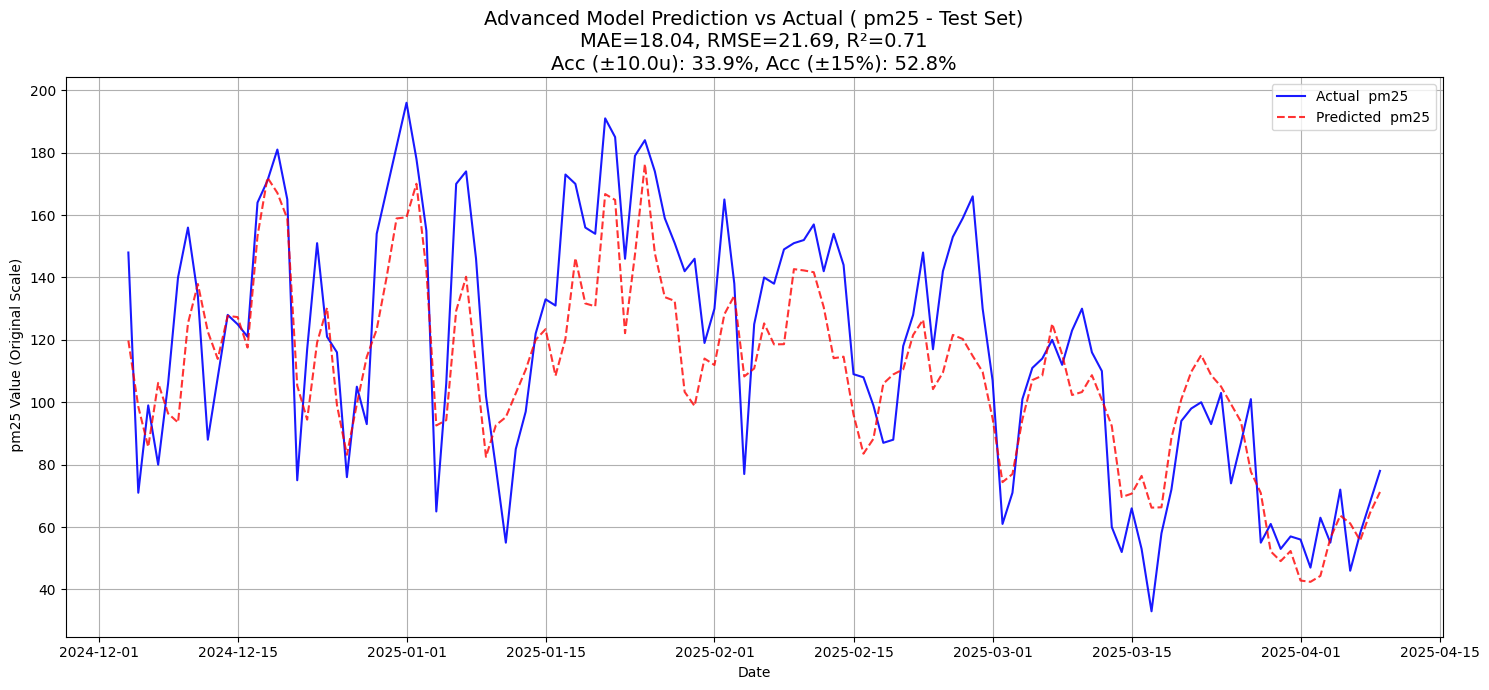

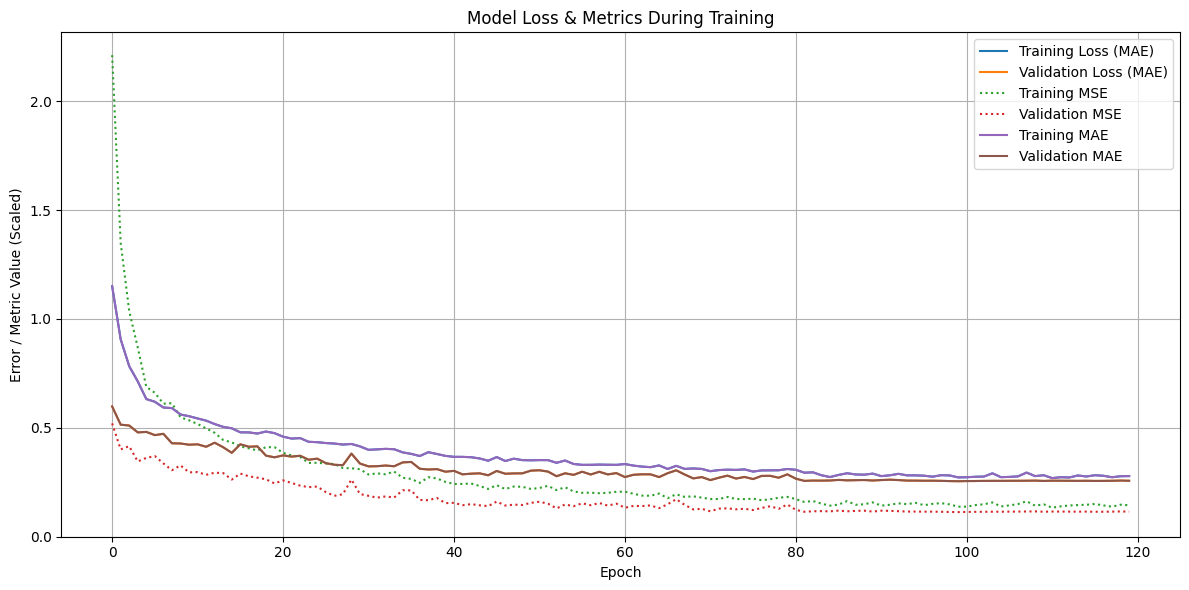

In [147]:
print("\n--- Evaluating Model on Test Set ---")
# Predict on the test set (scaled features)
predicted_scaled = model.predict(X_test)

# Inverse transform the predictions and the actual test targets
# Ensure y_test is reshaped correctly if it's flat
predicted = target_scaler.inverse_transform(predicted_scaled)
actual = target_scaler.inverse_transform(y_test.reshape(-1, 1))

# Flatten arrays for metrics
actual = actual.flatten()
predicted = predicted.flatten()

# Calculate standard metrics
mae = mean_absolute_error(actual, predicted)
rmse = np.sqrt(mean_squared_error(actual, predicted))
r2 = r2_score(actual, predicted)

# Calculate custom "accuracy" metrics
absolute_tolerance = 10.0 # PM2.5 units
relative_tolerance = 0.15 # 15%

absolute_accuracy = np.mean(np.abs(actual - predicted) <= absolute_tolerance) * 100
non_zero_mask = np.abs(actual) > 1e-6 # Avoid division by zero/small numbers
relative_accuracy = np.mean(
    np.abs(actual[non_zero_mask] - predicted[non_zero_mask]) / np.abs(actual[non_zero_mask]) <= relative_tolerance
) * 100 if np.any(non_zero_mask) else 0.0

print("\n--- Final Model Evaluation (Test Set) ---")
print(f"Mean Absolute Error (MAE): {mae:.4f}")
print(f"Root Mean Squared Error (RMSE): {rmse:.4f}")
print(f"R² Score: {r2:.4f}")
print("-" * 30)
print(f"Accuracy (within ±{absolute_tolerance:.1f} units): {absolute_accuracy:.2f}%")
print(f"Accuracy (within ±{relative_tolerance*100:.0f}%): {relative_accuracy:.2f}%")
print("-" * 30)
if r2 < 0.6:
    print("NOTE: R² score is relatively low. Model may struggle with variance.")
    print("Consider adding meteorological features, more advanced imputation, or further tuning.")
elif mae > 15: # Adjust threshold based on typical PM2.5 levels
    print("NOTE: MAE seems high. Check for outlier predictions or systematic bias.")

print("\n--- Generating Plots ---")

# Plot Predictions vs Actuals using Test Dates
plt.figure(figsize=(15, 7))
plt.plot(test_dates_seq, actual, label=f'Actual {TARGET_COLUMN}', linewidth=1.5, alpha=0.9, color='blue')
plt.plot(test_dates_seq, predicted, label=f'Predicted {TARGET_COLUMN}', linewidth=1.5, alpha=0.8, color='red', linestyle='--')

title_text = (
    f'Advanced Model Prediction vs Actual ({TARGET_COLUMN} - Test Set)\n'
    f'MAE={mae:.2f}, RMSE={rmse:.2f}, R²={r2:.2f}\n'
    f'Acc (±{absolute_tolerance:.1f}u): {absolute_accuracy:.1f}%, Acc (±{relative_tolerance*100:.0f}%): {relative_accuracy:.1f}%'
)
plt.title(title_text, fontsize=14)
plt.xlabel('Date')
plt.ylabel(f'{TARGET_COLUMN} Value (Original Scale)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# Plot Training History
if history is not None and hasattr(history, 'history'):
    plt.figure(figsize=(12, 6))
    loss_metrics = {'loss': 'Training Loss (MAE)', 'val_loss': 'Validation Loss (MAE)',
                    'mse': 'Training MSE', 'val_mse': 'Validation MSE',
                    'mae': 'Training MAE', 'val_mae': 'Validation MAE'} # Added MAE explicitly

    for metric, label in loss_metrics.items():
         if metric in history.history:
             style = ':' if 'mse' in metric else '-' # Dotted for MSE
             plt.plot(history.history[metric], label=label, linestyle=style)

    plt.title('Model Loss & Metrics During Training')
    plt.xlabel('Epoch')
    plt.ylabel('Error / Metric Value (Scaled)')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.ylim(bottom=0) # Often useful to start y-axis at 0 for loss plots
    plt.show()
else:
    print("Training history not available for plotting.")

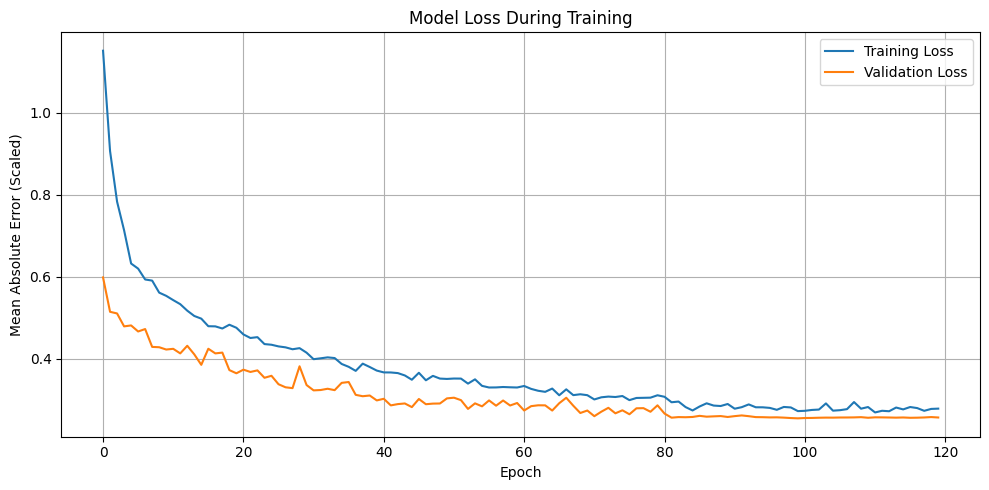

In [148]:

#After you compile, you need to find important features
from sklearn.ensemble import RandomForestRegressor
from sklearn.inspection import permutation_importance
import pandas as pd
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import matplotlib.pyplot as plt
import numpy as np

#First convert X_train into a Pandas dataframe:
#You have a history object available to use for this now
#If there are issues with loading, see an earlier code in that process and load from there

if history is not None and hasattr(history, 'history'):
    plt.figure(figsize=(10, 5))
    if 'loss' in history.history:
        plt.plot(history.history['loss'], label='Training Loss')
    if 'val_loss' in history.history:
        plt.plot(history.history['val_loss'], label='Validation Loss')

    # Determine the loss function used during training for the label
    loss_label = 'Loss' # Default
    if model.loss == 'mae':
      loss_label = 'Mean Absolute Error (Scaled)'
    elif model.loss == 'mse':
      loss_label = 'Mean Squared Error (Scaled)'
    # Add more elif for other loss functions if needed

    plt.title('Model Loss During Training')
    plt.xlabel('Epoch')
    plt.ylabel(loss_label)

    # Only show legend if there are labels to show
    if 'loss' in history.history or 'val_loss' in history.history:
      plt.legend()

    plt.grid(True)
    plt.tight_layout()
    plt.show()
else:
    print("Training history not available for plotting.")